# Dataset Generation

### Initial imports

In [1]:
import pybullet as p
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

### Simulation Data Collection
Next, we generate and collect data from physics simulations of systems composed of a given amount of balls. The simulation is run for a specified number of systems.

#### Parameters
num_systems: The number of systems to simulate.

num_balls: The number of balls in each system.

color: True if the balls are identified by color, False if they are all black.

#### Default Parameters
density: The density of the balls.

radius: The radius of the balls.

#### Dataset Initialization
A numpy array dataset is created to store the collected data. It has dimensions (num_systems, 8num_balls+1), where each row represents a system and each column corresponds to a particular property of the system.

#### Simulation Execution
For each system, the simulation is initialized using PyBullet's physics engine. Gravity is set to zero, and certain parameters of the physics engine are adjusted.

The balls in the system are created and positioned randomly on a plane. Each ball is assigned a random velocity. The balls' properties such as position, orientation, and velocity are retrieved and stored for the initial frame.

The simulation is stepped forward, and the properties of the balls for the second and third frames are recorded similarly. The positions and velocities of the balls in each frame are stored in separate numpy arrays.

The collected data, including the position and velocity information for the three frames, as well as the velocity magnitude, are stored in the dataset array.

Finally, the simulation is cleaned up by disconnecting from the physics server.

In [2]:
# Modify this parameters to change imageset properties
num_systems = 10000
num_balls = 3
color = False

# Default parameters (do not modify)
density = 1
radius = 5

# Initialization of the dataset
dataset = np.zeros((num_systems, 8*num_balls+1))

# Generation of all samples
for i in tqdm(range(num_systems)):
    # Initialize the simulation
    physicsClient = p.connect(p.DIRECT)
    p.setGravity(0, 0, 0)
    p.setPhysicsEngineParameter(enableConeFriction=0, enableSAT=0)

    # Creation of balls
    balls = []
    velocityMagnitude = np.random.uniform(20, 80)
    for _ in range(num_balls):
        # Create a sphere collision shape
        sphere_shape_id = p.createCollisionShape(p.GEOM_SPHERE, radius=radius)

        # Create a multi-body object with the sphere visual shape
        visualShapeId = -1
        ball_id = p.createMultiBody(density, sphere_shape_id, visualShapeId)

        # Set random position of balls on the plane
        p.resetBasePositionAndOrientation(ball_id, (np.random.uniform(-1,1), np.random.uniform(-1,1), 0), p.getQuaternionFromEuler([0, 0, 0]))

        # Set velocity direction (magnitude already defined)
        velocity_x = np.random.uniform(-1, 1)
        velocity_y = np.sqrt(1 - velocity_x**2) * (-1)**np.random.randint(2)
        baseVelocity = velocityMagnitude * np.array([velocity_x, velocity_y, 0])
        p.resetBaseVelocity(ball_id, baseVelocity, (0, 0, 0))     

        # Remove all factors that can affect the velocity (external forces, collisions, etc.)
        p.changeDynamics(ball_id, -1, linearDamping=0, angularDamping=0)
        p.applyExternalForce(ball_id, -1, [0, 0, 0], [0, 0, 0], p.WORLD_FRAME)
        p.applyExternalTorque(ball_id, -1, [0, 0, 0], p.WORLD_FRAME)
        p.changeDynamics(ball_id, -1, lateralFriction=0, restitution=0)
        p.setCollisionFilterGroupMask(ball_id, -1, 0, 0)

        # Store balls
        balls.append(ball_id)

    # Step of the simulation
    time_step = 0.01
        
    # Record ball position and velocity information
    image_t0 = np.zeros((num_balls, 2))
    image_t1 = np.zeros((num_balls, 2))
    image_t2 = np.zeros((num_balls, 2))
    velocities_vector = np.zeros((num_balls, 2))
    # Initial frame
    for ball_id in balls:
        image_t0[ball_id % num_balls] = p.getBasePositionAndOrientation(ball_id)[0][0], p.getBasePositionAndOrientation(ball_id)[0][1]
        #Velocity vector remains constant (stored only once)
        velocities_vector[ball_id % num_balls] = p.getBaseVelocity(ball_id)[0][0], p.getBaseVelocity(ball_id)[0][1]
    p.stepSimulation()
    # Second frame
    for ball_id in balls:
        image_t1[ball_id % num_balls] = p.getBasePositionAndOrientation(ball_id)[0][0], p.getBasePositionAndOrientation(ball_id)[0][1]
    p.stepSimulation()
    # Third frame
    for ball_id in balls:
        image_t2[ball_id % num_balls] = p.getBasePositionAndOrientation(ball_id)[0][0], p.getBasePositionAndOrientation(ball_id)[0][1]
    # Save image and velocity data to dataset
    dataset[i][0:2*num_balls] = image_t0.reshape(2*num_balls)
    dataset[i][2*num_balls:4*num_balls] = image_t1.reshape(2*num_balls)
    dataset[i][4*num_balls:6*num_balls] = image_t2.reshape(2*num_balls)
    dataset[i][6*num_balls:8*num_balls] = velocities_vector.reshape(2*num_balls)
    dataset[i][-1] = velocityMagnitude
    # Clean up
    p.disconnect()

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:54<00:00, 87.54it/s]


### Visualization and Analysis
A visualization and data check is performed to see that everything is working correctly.
The scatter points plotted in red ('r'), yellow ('y') and blue ('b') correspond to the position in the initial, second and third frames respectively.

In addition, we calculate the length between the positions of the first ball in the initial frame and the second frame using the Euclidean distance formula to check if the speed and distance ratio is correct.

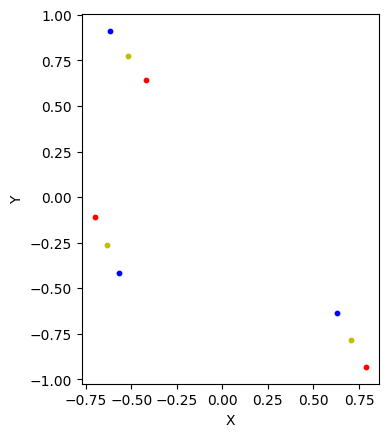

Length: 0.1684437303419911
Speed: 40.426495282077866
Speed * Length: 120.00000000000001


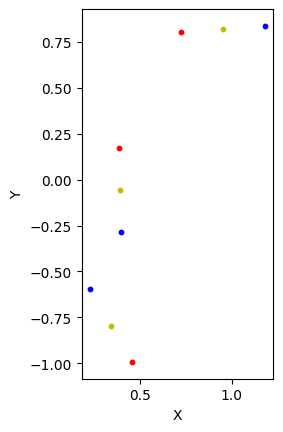

Length: 0.22801051583095455
Speed: 54.722523799429084
Speed * Length: 119.99999999999999


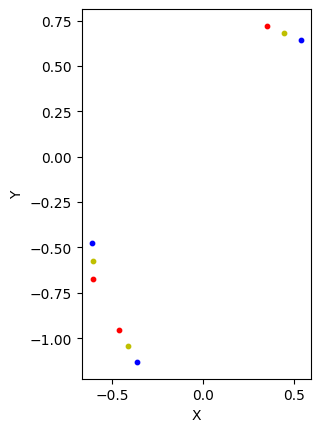

Length: 0.10056256023949617
Speed: 24.13501445747909
Speed * Length: 120.00000000000006


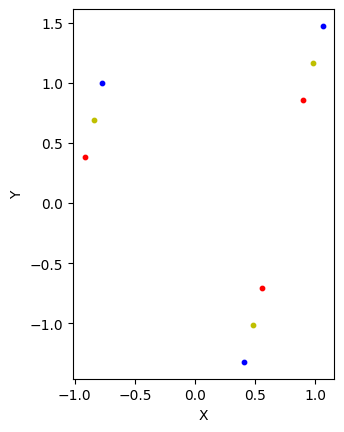

Length: 0.31611344398335856
Speed: 75.86722655600605
Speed * Length: 119.99999999999999


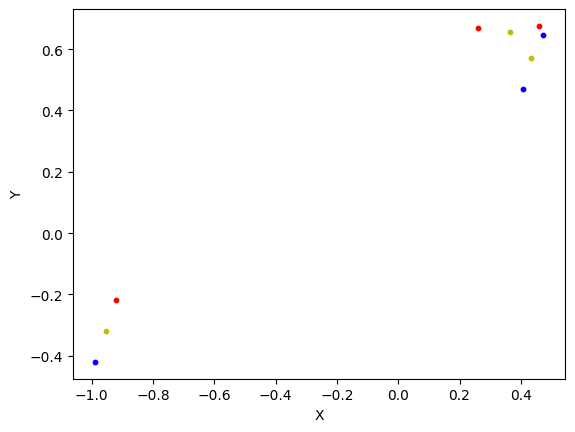

Length: 0.10676978721946222
Speed: 25.624748932670933
Speed * Length: 120.0


In [3]:
for i in range(5):
    fig, ax = plt.subplots()

    for j in range(num_balls):
        # Ball position in frame 1
        ax.scatter(dataset[i][2*j], dataset[i][2*j+1], c='r', s=10)
        # Ball position in frame 2
        ax.scatter(dataset[i][2*(j+num_balls)], dataset[i][2*(j+num_balls)+1], c='y', s=10)
        # Ball position in frame 3
        ax.scatter(dataset[i][2*(j+2*num_balls)], dataset[i][2*(j+2*num_balls)+1], c='b', s=10)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal', adjustable='box')
    plt.show()

    print('Length: ' + str(np.sqrt((dataset[i][0] - dataset[i][2*num_balls])**2 + (dataset[i][1] - dataset[i][2*num_balls+1])**2)))
    print('Speed: ' + str(dataset[i][-1]))
    print('Speed * Length: ' + str(dataset[i][-1] / np.sqrt((dataset[i][0] - dataset[i][4*num_balls])**2 + (dataset[i][1] - dataset[i][4*num_balls+1])**2)))

### Coordinate Extraction
First, we calculate the maximum and minimum values from the position coordinates and add a small margin to them. These values will be used to set the limits of the x and y axes in the plots. We would have a squared grid with the same limits for both axes.

After that, we store the coordinates of each balls for all systems. We need to plot the balls separately to store their coordinates relative to the image, not to the system, and we print them separately to be able to identify all pixels correspondig to that ball. We calculate the mean x and y coordinates (what is the center pixel of the ball region) for each frame and store them in the coordinates array.

In [4]:
# Limits of axes to have a square grid that contains all balls for any system
ax_max = round(np.max(dataset[:,:6*num_balls]) + 0.1, 1)
ax_min = round(np.min(dataset[:,:6*num_balls]) - 0.1, 1)

coordinates = np.zeros((num_systems, 8*num_balls))

for i in tqdm(range(num_systems)):
    # Extraction of ball coordinates is done per ball
    for j in range(num_balls):
        non_white_x_t0 = []
        non_white_y_t0 = []
        non_white_x_t1 = []
        non_white_y_t1 = []
        non_white_x_t2 = []
        non_white_y_t2 = []

        for k in range(3):
            # We plot the ball at the respective frame and set the images to have the same axes
            plt.scatter(dataset[i, 2*j + 2*num_balls*k], dataset[i, 2*j + 2*num_balls*k + 1], c='k', s=2)
            plt.xlim(ax_min, ax_max)
            plt.ylim(ax_min, ax_max)
            plt.axis('off')
            plt.tight_layout(pad=0.0)
            
            # Set the figure size to your desired dimensions
            fig = plt.gcf()
            fig.set_size_inches(.32, .32)  # Adjust the size as needed

            # Convert the plot to an array
            fig.canvas.draw()
            plot_array = np.array(fig.canvas.renderer.buffer_rgba())

            # Convert the RGBA array to grayscale
            plot_gray = np.dot(plot_array[..., :3], [0.2989, 0.5870, 0.1140])
            plot_gray /= np.max(plot_gray)

            fig.canvas.renderer.clear()
            fig.clear()
            plt.close()

            # Store all pixels in ball region in the three frames (images are 32x32)
            for m in range(32):
                for n in range(32):
                    if plot_gray[m, n] != 1:
                        # Frame 0
                        if k == 0:
                            if m not in non_white_y_t0: non_white_y_t0.append(m)
                            if n not in non_white_x_t0: non_white_x_t0.append(n)
                        # Frame 1
                        elif k == 1:
                            if m not in non_white_y_t1: non_white_y_t1.append(m)
                            if n not in non_white_x_t1: non_white_x_t1.append(n)
                        # Frame 2
                        elif k == 2:
                            if m not in non_white_y_t2: non_white_y_t2.append(m)
                            if n not in non_white_x_t2: non_white_x_t2.append(n)
            
        # Calculate the center pixel of each ball and the velocity vector
        coordinates[i, 2*j : 2*(j+1)] = np.mean(non_white_y_t0), np.mean(non_white_x_t0)
        coordinates[i, 2*num_balls + 2*j : 2*num_balls + 2*(j+1)] = np.mean(non_white_y_t1), np.mean(non_white_x_t1)
        coordinates[i, 4*num_balls + 2*j : 4*num_balls + 2*(j+1)] = np.mean(non_white_y_t2), np.mean(non_white_x_t2)
        coordinates[i, 6*num_balls + 2*j : 6*num_balls + 2*(j+1)] = np.mean(non_white_x_t1) - np.mean(non_white_x_t0), np.mean(non_white_y_t1) - np.mean(non_white_y_t0)

100%|██████████| 10000/10000 [1:18:17<00:00,  2.13it/s] 


### Storing Images and Coordinates
First, we set (and create if needed) the input and output directory paths based on the number of balls and the color flag.

Then, we iterate over each system in the dataset. We extract the ball coordinates for each frame (balls_coordinates_t0, balls_coordinates_t1, balls_coordinates_t2) and generate and store the corresponding image.

Lastly, we save the coordinates array as a CSV file with the respective naming convention.

In [5]:
# Set directories name
path = 'data/' + str(num_balls) + 'ball' + '_color' * color + '/'
input_path = path + 'Input/'
output_path = path + 'Output/'

# Create directories if needed
if not os.path.exists(path): os.makedirs(path)
if not os.path.exists(input_path): os.makedirs(input_path)
if not os.path.exists(output_path): os.makedirs(output_path)

# Color of balls
if color: colors = ["r", "b", "g"]
else: colors = ["k"]

for i in tqdm(range(num_systems)):
    # Generate needed information to save input and output with same dimensions
    balls_coordinates_t0 = dataset[i, 0 : 2*num_balls : 2], dataset[i, 1 : 2*num_balls : 2]
    balls_coordinates_t1 = dataset[i, 2*num_balls : 4*num_balls : 2], dataset[i, 2*num_balls+1 : 4*num_balls : 2]
    balls_coordinates_t2 = dataset[i, 4*num_balls : 6*num_balls : 2], dataset[i, 4*num_balls+1 : 6*num_balls : 2]

    # Generate input images and save
    plt.figure(figsize=(.42, .42))
    plt.scatter(balls_coordinates_t0[0], balls_coordinates_t0[1], color=colors, s=2)
    plt.xlim(ax_min, ax_max)
    plt.ylim(ax_min, ax_max)
    plt.axis('off')
    plt.savefig(input_path + 'image1_{}.png'.format(str(i).zfill(4)), bbox_inches='tight', pad_inches=0.0)
    plt.close()

    plt.figure(figsize=(.42, .42))
    plt.scatter(balls_coordinates_t1[0], balls_coordinates_t1[1], color=colors, s=2)
    plt.xlim(ax_min, ax_max)
    plt.ylim(ax_min, ax_max)
    plt.axis('off')
    plt.savefig(input_path + 'image2_{}.png'.format(str(i).zfill(4)), bbox_inches='tight', pad_inches=0.0)
    plt.close()

    # Generate output image and save
    plt.figure(figsize=(.42, .42))
    plt.scatter(balls_coordinates_t2[0], balls_coordinates_t2[1], color=colors, s=2)
    plt.xlim(ax_min, ax_max)
    plt.ylim(ax_min, ax_max)
    plt.axis('off')
    plt.savefig(output_path + 'image{}.png'.format(str(i).zfill(4)), bbox_inches='tight', pad_inches=0.0)
    plt.close()

# Save coordinates data
np.savetxt(path + 'coordinates.csv', coordinates, delimiter=',')

100%|██████████| 10000/10000 [31:32<00:00,  5.28it/s] 


In [6]:
print(ax_max)
print(ax_min)

1.7
-1.8
